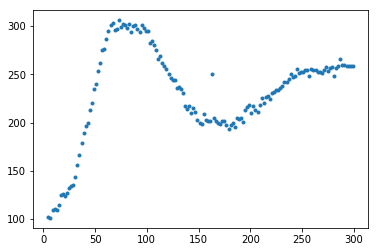

In [69]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import pdb

%matplotlib inline

df = pd.read_excel("TestData2.xlsx")
xdata = np.array(df['TIME'])
ydata = np.array(df['Actual Value']) 

noise = np.random.normal(0, 3, len(ydata))
ydata = ydata + noise
ydata[79] = 250
data = dict(zip(xdata, ydata))
plt.plot(xdata, ydata, '.')
plt.show()


In [70]:
def Calc_sigma(xdata, ydata, slope, intercept, df = None):
    ycalc = (slope * xdata + intercept)
    diff = (ydata - ycalc)
    SSE = np.sum([i**2 for i in diff])
    n = len(xdata)
    if (df == None):
        df = n - 2
    return np.sqrt((SSE / df)), df

def Calc_interval(alpha, x_current_trend, y_current_trend, x_next_pred, slope, intercept, sigma = None, df=None):
    n = len(x_current_trend)
    if (df == None):
        df = n - 2
    t_stat = stats.t.ppf(1 - alpha, df)
    if sigma == None:
        sigma, df = Calc_sigma(x_current_trend, y_current_trend, slope, intercept)
    
    xmean = np.mean(x_current_trend)
    num = (x_next_pred - xmean)**2
    diff = x_current_trend - xmean
    den = np.sum([i**2 for i in diff])
    term = np.sqrt(1 + (1 / n) + num/den)
    interval = t_stat * sigma * term
    return interval

def Calc_Outlier(n, alpha, x_current_trend, y_current_trend, xdata, ydata, sigma, df):
    # step 7a - assume y[n] is an outlier
    # eliminate y[n] from the data set
    if (len(xdata) <= n+2):
        return x_current_trend, y_current_trend, 3, sigma, df
    
    x_7a = np.append(x_current_trend, xdata[n + 1])
    y_7a = np.append(y_current_trend, ydata[n + 1])
    slope_7a, intercept_7a, r_value, p_value, std_err = stats.linregress(x_7a, y_7a)
    sigma_7a, df_7a = Calc_sigma(x_current_trend, y_current_trend, slope_7a, intercept_7a)
    interval_7a = Calc_interval(alpha, x_7a, y_7a, xdata[n + 2], slope_7a, intercept_7a, sigma_7a, df_7a)
    
    x_7b = [xdata[n], xdata[n+1]]
    y_7b = [ydata[n], ydata[n+1]]
    slope_7b, intercept_7b, r_value, p_value, std_err = stats.linregress(x_7b, y_7b)
    interval_7b = Calc_interval(alpha, x_7b, y_7b, xdata[n + 2], slope_7b, intercept_7b, sigma, df)
    
    y_pred_7a = slope_7a * xdata[n + 2] + intercept_7a
    y_pred_7b = slope_7b * xdata[n + 2] + intercept_7b

    in7a = y_pred_7a - interval_7a <= ydata[n+2] <= y_pred_7a + interval_7a
    in7b = y_pred_7b - interval_7b <= ydata[n+2] <= y_pred_7b + interval_7b
#     pdb.set_trace()

    if (in7a and not in7b):
        #step 8a - remove outlier x[n]
        print("Outlier at x =", xdata[n])
        x_current_trend = np.append(x_current_trend, xdata[n + 1])
        y_current_trend = np.append(y_current_trend, ydata[n + 1])
        x_current_trend = np.append(x_current_trend, xdata[n + 2])
        y_current_trend = np.append(y_current_trend, ydata[n + 2])
        return Calc_trend(x_current_trend, y_current_trend, xdata, ydata, alpha)
    elif (in7b and not in7a):
        #step 8b - new trend has started at x[n]
        return x_current_trend, y_current_trend, 3, sigma, df
    elif (in7a and in7b):
        #step 8c
        x_current_trend = np.append(x_current_trend, xdata[n + 1])
        y_current_trend = np.append(y_current_trend, ydata[n + 1])
        return Calc_Outlier(n + 1, alpha, x_current_trend, y_current_trend, xdata, ydata, sigma, df)
    elif (not in7a and not in7b):
        #step 8d
        x_current_trend = np.append(x_current_trend, xdata[n + 1])
        y_current_trend = np.append(y_current_trend, ydata[n + 1])
        return Calc_Outlier(n + 1, alpha, x_current_trend, y_current_trend, xdata, ydata, sigma, df)
    
    return

def Calc_trend(x_current_trend, y_current_trend, xdata, ydata, alpha, sigma=None, df=None):
    
    #step 2
    slope, intercept, r_value, p_value, std_err = stats.linregress(x_current_trend, y_current_trend)
    if (sigma == None or df == None):
        sigma, df = Calc_sigma(x_current_trend, y_current_trend, slope, intercept)
    
    n = len(x_current_trend)
    if n + 1 >= len(xdata):
        return x_current_trend, y_current_trend, 0, None, None
    
    x_next_pred = xdata[n]
    y_next_pred = slope * x_next_pred + intercept
    # step 3
    interval = Calc_interval(alpha, x_current_trend, y_current_trend, x_next_pred, slope, intercept, sigma, df)
    
    # step 4
    if (y_next_pred - interval <= ydata[n] <= y_next_pred + interval):
        # step 4a - point belongs to the current trend
        x_current_trend = np.append(x_current_trend, xdata[n])
        y_current_trend = np.append(y_current_trend, ydata[n])
        return Calc_trend(x_current_trend, y_current_trend, xdata, ydata, alpha)
    else:
        # step 4b - point is outlier or a new trend
        
        # step 5
        y_next_skipped = slope * xdata[n+1] + intercept
        
        new_interval = Calc_interval(alpha, x_current_trend, y_current_trend, xdata[n+1], slope, intercept, sigma, df)
        if (y_next_skipped - new_interval < ydata[n + 1] < y_next_skipped + new_interval):
            return Calc_Outlier(n, alpha, x_current_trend, y_current_trend, xdata, ydata, sigma, df)
        else:
            # step 6 - new trend has started
            return x_current_trend, y_current_trend, 2, sigma, df


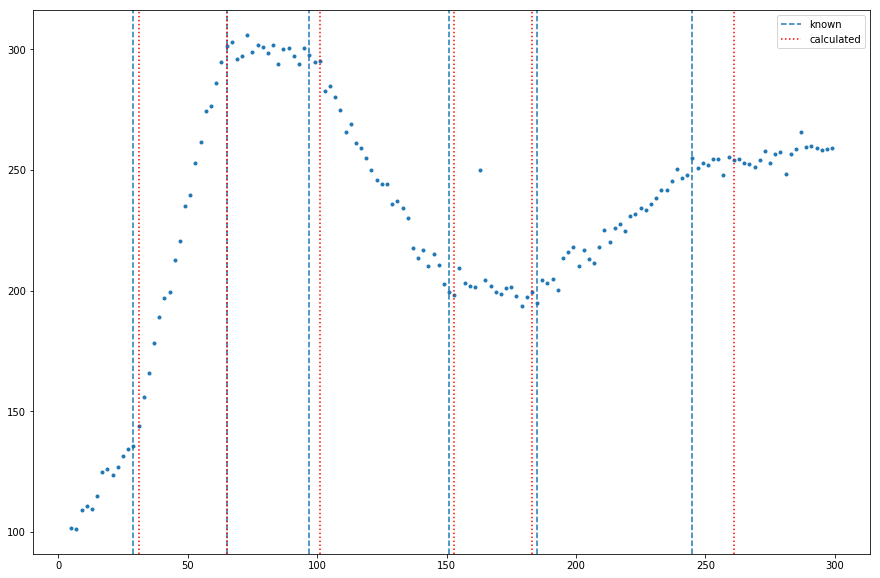

In [77]:
import pdb
plt.rcParams["figure.figsize"] = (15,10)

def Calculate_breaks(xdata, ydata, n, alpha, trend_start):
    initial_len = len(xdata)
    y_current_trend = ydata[trend_start:trend_start+n]
    x_current_trend = xdata[trend_start:trend_start+n]
    y_trends = []
    x_trends = []
    processed = 0
    sigma = None
    df = None
    while(processed < initial_len and n!=0):
        x_current_trend, y_current_trend, n, sigma, df = Calc_trend(x_current_trend, y_current_trend, xdata, ydata, alpha, sigma, df)
#         y_current_trend = ydata[trend_start:trend_start+len(x_current_trend)]
        x_trends.append(x_current_trend)
        y_trends.append(y_current_trend)
        trend_start = np.where(xdata == x_current_trend[-1])[0][0] + 1
        processed += trend_start
        xdata = xdata[trend_start:]
        ydata = ydata[trend_start:]
        y_current_trend = ydata[0:n]
        x_current_trend = xdata[0:n]

    breaks = []
    for i in range(len(x_trends)):
        breaks.append(x_trends[i][-1])
    
    return breaks

alpha = 0.005 #increasing will increase the number of trends found
n_start = 5
breaks = Calculate_breaks(xdata, ydata, n_start, alpha, 0)

plt.plot(xdata, ydata, '.')

#known_breaks = [65, 125, 185] #TestData.xlsx
known_breaks = [29, 65, 97, 151, 185, 245 ] #TestData2.xlsx

for i in range(len(known_breaks)):
    plt.axvline(known_breaks[i], linestyle='--', label='known')
    
for i in range(len(breaks)-1):
    plt.axvline(breaks[i], linestyle=':', color='red', label='calculated')


handles, labels = plt.gca().get_legend_handles_labels()
handle_list, label_list = [], []
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)

plt.legend(handle_list, label_list)

plt.show()